In [1]:
import jax
from jax.flatten_util import ravel_pytree
from jax.tree_util import tree_map, tree_structure
import jax.numpy as jnp
import optax

from bde.models.models import Fnn
from bde.training.trainer import FnnTrainer
from bde.bde_builder import BdeBuilder
from bde.viz.plotting import plot_pred_vs_true
from bde.data.dataloader import DataLoader
from bde.data.preprocessor import DataPreProcessor
from bde.loss.loss import  LossMSE
from bde.sampler.mile_wrapper import MileWrapper
from bde.bde_evaluator import BDEPredictor

from bde.sampler.warmup import custom_mclmc_warmup
from bde.sampler.probabilistic import ProbabilisticModel
from bde.sampler.prior import Prior, PriorDist

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from bde.tests.metrics import metrics

import sys
import os

import pandas

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
data = fetch_openml(name="airfoil_self_noise", as_frame=True)

X = data.data.values   # shape (1503, 5)
y = data.target.values.reshape(-1, 1)  # shape (1503, 1)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)
X_test = jnp.array(X_test, dtype=jnp.float32)
y_test = jnp.array(y_test, dtype=jnp.float32)

Xmu, Xstd = jnp.mean(X_train, 0), jnp.std(X_train, 0) + 1e-8
Ymu, Ystd = jnp.mean(y_train, 0), jnp.std(y_train, 0) + 1e-8

Xtr = (X_train - Xmu) / Xstd
Xte = (X_test  - Xmu) / Xstd
ytr = (y_train - Ymu) / Ystd
yte = (y_test  - Ymu) / Ystd

/Users/yellouz/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/datasets/_openml.py:320: UserWarning: Multiple active versions of the dataset matching the name airfoil_self_noise exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=43919
- version 8, status: active
  url: https://www.openml.org/search?type=data&id=44957

  warn(warning_msg)


In [3]:
sizes = [5, 16, 16, 2]

In [4]:
bde = BdeBuilder(
        sizes, 
        n_members=1, 
        epochs=1000, 
        optimizer=optax.adam(1e-4)
        )

In [5]:
bde.fit(
        x=Xtr, 
        y=ytr, 
        epochs=1000
        )

0 1.5507210493087769
100 1.4237060546875
200 1.342346429824829
300 1.283091425895691
400 1.2303383350372314
500 1.1769062280654907
600 1.1228965520858765
700 1.0651403665542603
800 1.005088448524475
900 0.9470277428627014


In [6]:
initial_params = bde.all_fnns["fnn_0"]
prior = PriorDist.STANDARDNORMAL.get_prior()
model = ProbabilisticModel(module=bde.members[0], params=initial_params, prior=prior, n_batches=1)

logdensity_fn = lambda params: model.log_unnormalized_posterior(params, x=Xtr, y=ytr)

In [7]:
warmup = custom_mclmc_warmup(
    logdensity_fn=logdensity_fn,
    diagonal_preconditioning=False,
    step_size_init=1e-4,
    desired_energy_var_start=0.5,
    desired_energy_var_end=0.1,
    trust_in_estimate=1.5,
    num_effective_samples=100,
    )

In [8]:
rng_key = jax.random.PRNGKey(0)
results = warmup.run(rng_key, position=initial_params, num_steps=1000)
print("step_size:", results.parameters.step_size)
print("L:", results.parameters.L)
post_end = logdensity_fn(results.state.position)
print("end-of-warmup post:", post_end)

---Initialize warmup---
---Search for optimal Parameters---
Initial L:  20.049938
step 0 | ok=True | step_size=9.999999747378752e-05 | cap=3.4028234663852886e+38 | dE=-0.000244140625
step 1 | ok=True | step_size=0.002143966732546687 | cap=3.4028234663852886e+38 | dE=0.0
step 2 | ok=True | step_size=0.00240921089425683 | cap=3.4028234663852886e+38 | dE=-0.0001220703125
step 3 | ok=True | step_size=0.002581746783107519 | cap=3.4028234663852886e+38 | dE=0.0001220703125
step 4 | ok=True | step_size=0.0027129969093948603 | cap=3.4028234663852886e+38 | dE=0.0001220703125
step 5 | ok=True | step_size=0.002820485271513462 | cap=3.4028234663852886e+38 | dE=-0.000244140625
step 6 | ok=True | step_size=0.0029128168243914843 | cap=3.4028234663852886e+38 | dE=0.0
step 7 | ok=True | step_size=0.002993483329191804 | cap=3.4028234663852886e+38 | dE=0.0001220703125
step 8 | ok=True | step_size=0.0030660214833915234 | cap=3.4028234663852886e+38 | dE=-0.0001220703125
step 9 | ok=True | step_size=0.003132

In [9]:
sampler = MileWrapper(logdensity_fn, step_size=results.parameters.step_size , L=results.parameters.L,)
positions, infos, state = sampler.sample(rng_key=rng_key, init_position = results.state.position, num_samples = 10000, thinning=10)

In [10]:
# infos is something like MCLMCInfo(logdensity=..., kinetic_change=..., energy_change=...)
ld = jnp.ravel(infos.logdensity)       # log posterior per step, shape (S,)
dE = jnp.ravel(infos.energy_change)    # shape (S,)
kc = jnp.ravel(infos.kinetic_change)   # shape (S,)

print("finite?", bool(jnp.all(jnp.isfinite(ld))),
                  bool(jnp.all(jnp.isfinite(dE))),
                  bool(jnp.all(jnp.isfinite(kc))))
print("dE mean:", float(dE.mean()))
print("dE q05/median/q95:", [float(x) for x in jnp.quantile(dE, jnp.array([.05,.5,.95]))])

finite? True True True
dE mean: 19.640178680419922
dE q05/median/q95: [-25.971725463867188, 9.181427001953125, 103.166015625]


In [11]:
fnn = bde.members[0]

preds = BDEPredictor(fnn, positions, Xte)

In [12]:
means, stds = preds.get_preds()

In [16]:
Ymu_s  = jnp.squeeze(Ymu)     # shape ()
Ystd_s = jnp.squeeze(Ystd)   
# If means/stds are per-sample: shape (N, S) —> outputs (N, S)
# If they are already averaged: shape (N,) —> outputs (N,)
y_pred_sampled = means * Ystd + Ymu
y_err_sampled  = stds  * Ystd               # std scales linearly
y_true         = (yte * Ystd + Ymu).squeeze(-1)


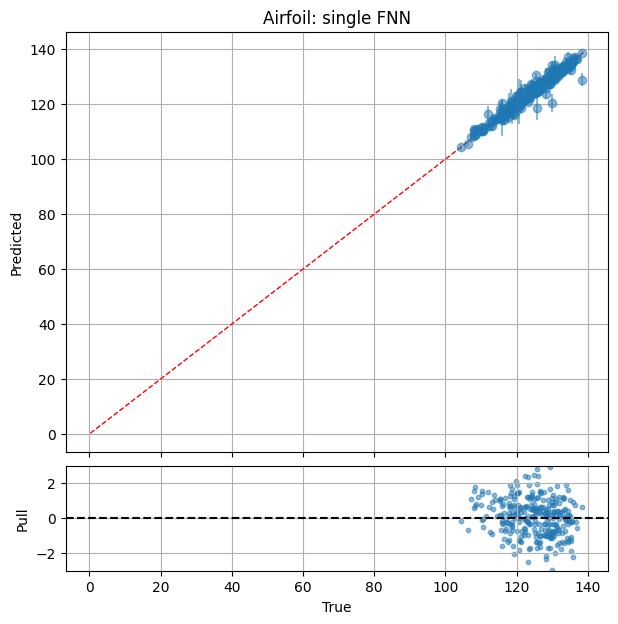

In [17]:
fig = plt.figure(figsize=(7,7))
gs  = gridspec.GridSpec(2,1, height_ratios=[4,1], hspace=0.05)

ax = plt.subplot(gs[0])
ax.errorbar(y_true, y_pred_sampled, yerr=y_err_sampled, fmt='o', alpha=0.5)
m, M = float(min(y_true.min(), y_err_sampled.min())), float(max(y_true.max(), y_pred_sampled.max()))
ax.plot([m,M],[m,M], 'r--', lw=1)
ax.set_ylabel("Predicted"); ax.set_title("Airfoil: single FNN"); ax.grid(True)
plt.setp(ax.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[1], sharex=ax)
pull_sampled = (y_pred_sampled - y_true) / y_err_sampled
ax2.axhline(0, color='k', ls='--')
ax2.scatter(y_true, pull_sampled, s=10, alpha=0.5)
ax2.set_xlabel("True"); ax2.set_ylabel("Pull"); ax2.set_ylim(-3,3); ax2.grid(True)


In [15]:
fnn.params = initial_params
pred_unsampled = fnn.predict(Xte)
mu_n_unsampled  = pred_unsampled[..., 0:1]
sigma_n_unsampled = jax.nn.sigmoid(pred_unsampled[..., 1:2]) + 1e-6

y_pred_unsampled = mu_n_unsampled * Ystd + Ymu
y_err_unsampled  = sigma_n_unsampled * Ystd

print("y_true shape:", y_true.shape, "y_pred shape:", y_pred_unsampled.shape, "yerr shape:", y_err_unsampled.shape)

yp_unsampled = np.asarray(y_pred_unsampled).ravel()
ye_unsampled = np.asarray(y_err_unsampled).ravel()
ye_unsampled= np.maximum(ye_unsampled, 1e-8)  # guard

acc_unsampled = bde.predictive_accuracy(y=yt, mu=yp_unsampled, sigma=ye_unsampled)
print(acc_unsampled)
print("mean sigma: ", jnp.mean(ye_unsampled))
print("mae: ", jnp.mean(jnp.abs(yt - yp_unsampled)))

fig = plt.figure(figsize=(7,7))
gs  = gridspec.GridSpec(2,1, height_ratios=[4,1], hspace=0.05)

ax = plt.subplot(gs[0])
ax.errorbar(yt, yp_unsampled, yerr=ye_unsampled, fmt='o', alpha=0.5)
m, M = float(min(yt.min(), yp_unsampled.min())), float(max(yt.max(), yp_unsampled.max()))
ax.plot([m,M],[m,M], 'r--', lw=1)
ax.set_ylabel("Predicted"); ax.set_title("Airfoil: single FNN"); ax.grid(True)
plt.setp(ax.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[1], sharex=ax)
pull_unsampled = (yp_unsampled - yt) / ye_unsampled
ax2.axhline(0, color='k', ls='--')
ax2.scatter(yt, pull_unsampled, s=10, alpha=0.5)
ax2.set_xlabel("True"); ax2.set_ylabel("Pull"); ax2.set_ylim(-3,3); ax2.grid(True)


y_true shape: (301,) y_pred shape: (301, 1) yerr shape: (301, 1)


NameError: name 'yt' is not defined